In [85]:
import numpy as np; import pandas as pd
import scipy as sp; import scipy.stats as st
import torch; import torch.nn as nn
#use numba's just-in-time compiler to speed things up
from numba import njit
from sklearn.preprocessing import StandardScaler; from sklearn.model_selection import train_test_split
import matplotlib as mp; import matplotlib.pyplot as plt; 
#reset matplotlib stle/parameters
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
#plt.style.use('seaborn-deep')
mp.rcParams['agg.path.chunksize'] = 10000
mp.rcParams['axes.linewidth'] = 1
font_legend = 15; font_axes=15
# %matplotlib inline
from joblib import  Memory

import copy; import sys; import os
from IPython.display import Image, display
from importlib import import_module

In [86]:
FONTSIZE=18
font = {'family': 'serif', 'weight':'normal', 'size':FONTSIZE}
mp.rc('font', **font)
mp.rc('text',usetex=True)

In [87]:
device  = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [88]:
SIR_data = pd.read_csv('../../data/SIR_data.csv.gz')
SIR_data

,alpha,beta,I,li
0,0.556824,0.432547,"[3.0000e+00,2.5413e+01,6.6242e+01,1.4076e+02,2...","[3.5465e-02,6.0205e-02,5.2629e-02,1.9994e-02,3..."
1,0.917183,0.617733,"[3.0000e+00,4.6435e+01,1.2668e+02,1.8865e+02,1...","[4.6994e-02,6.1737e-02,5.9416e-02,6.5321e-02,3..."
2,0.222595,0.684092,"[3.0000e+00,2.3207e+02,5.2139e+02,5.1127e+02,4...","[3.8465e-02,1.4980e-02,4.3391e-02,8.0108e-02,6..."
3,0.513685,0.231400,"[3.0000e+00,6.2250e+00,8.8920e+00,1.2593e+01,1...","[1.2181e-01,1.2303e-01,6.9494e-02,8.3929e-02,6..."
4,0.533168,0.343659,"[3.0000e+00,1.3872e+01,2.8699e+01,5.5722e+01,9...","[2.9563e-02,5.4805e-02,2.3345e-02,1.7169e-01,5..."
...,...,...,...,...
245,0.018504,0.236397,"[3.0000e+00,1.7329e+01,4.0684e+01,9.1622e+01,1...","[3.5029e-02,7.6161e-02,9.8830e-02,2.7422e-02,1..."
246,0.183638,0.371210,"[3.0000e+00,3.3838e+01,1.0217e+02,2.4462e+02,4...","[5.3251e-02,9.8350e-02,3.7443e-02,2.2209e-02,1..."
247,0.097239,0.421748,"[3.0000e+00,5.7375e+01,2.0121e+02,4.4055e+02,5...","[2.2518e-02,4.6346e-02,2.5197e-02,5.0298e-02,4..."
248,0.790416,0.309533,"[3.0000e+00,6.4540e+00,9.3210e+00,1.3244e+01,1...","[6.6862e-02,4.2194e-02,5.7831e-02,3.8413e-02,3..."


In [89]:
print(len(SIR_data.iloc[0]['I']))
print(len(SIR_data.iloc[0]['li']))

144
4401


In [253]:
print('alpha in [%.2f, %.2f]' % (SIR_data['alpha'].min(), SIR_data['alpha'].max()))
print('beta in [%.2f, %.2f]' % (SIR_data['beta'].min(), SIR_data['beta'].max()))

alpha in [0.00, 1.00]
beta in [0.20, 0.70]


In [90]:
def cdf(lst, x):

    count = sum(1 for num in lst if num <= x)
    return count / len(lst)


def flatten_SIR_data(df):
    """ and add cdf column"""
    alpha_l = []
    beta_l = []
    Infected_l = []
    li_l = []
    true_CDF_l=[]
    for rowind, row in df.iterrows():
        li = eval(row['li'])
        
        for lambda_val in li:
            true_CDF_l.append(cdf(li, lambda_val))
    
    for rowind, row in df.iterrows():
    #     Infected = eval(row['I'])
    #     Infected_l.append(Infected)
        
        li = eval(row['li'])
        li_l.append(li)

        
        alpha_r = np.full_like(li, row['alpha'])
        alpha_l.append(alpha_r)
        
        beta_r = np.full_like(li, row['beta'])
        beta_l.append(beta_r)
        
        
    
    # for arr in [alpha_l, beta_l, Infected_l, li_l]:
    #     arr = np.array(arr).flatten()
    alpha_l = np.array(alpha_l).flatten()
    beta_l = np.array(beta_l).flatten()
    # Infected_l = np.array(Infected_l).flatten()
    li_l = np.array(li_l).flatten()
    true_CDF_l = np.array(true_CDF_l).flatten()
    
    data_flat = pd.DataFrame({
        'alpha':alpha_l,
        'beta': beta_l,
        # 'I' :Infected_l,
        'li':li_l,
        'true_CDF':true_CDF_l 
    })
    
    return data_flat

In [91]:
SIR_data_flat = flatten_SIR_data(SIR_data)
SIR_data_flat

,alpha,beta,li,true_CDF
0,0.556824,0.432547,0.035465,0.3400
1,0.556824,0.432547,0.060205,0.6125
2,0.556824,0.432547,0.052629,0.5350
3,0.556824,0.432547,0.019994,0.0725
4,0.556824,0.432547,0.035213,0.3300
...,...,...,...,...
99995,0.498675,0.419194,0.077266,0.7225
99996,0.498675,0.419194,0.043796,0.4475
99997,0.498675,0.419194,0.014526,0.0250
99998,0.498675,0.419194,0.055118,0.5675


In [213]:
def split_t_x(df, target, source):
    # change from pandas dataframe format to a numpy 
    # array of the specified types
    t = np.array(df[target])
    x = np.array(df[source])
    return t, x

def getwholedata_delta_SIR():
    """ Get train test split arrays"""
    
    data = SIR_data_flat
        
    train_data, test_data = train_test_split(data, test_size=0.9)
    #split the train data (0.8 of whole set) again into 0.8*0.8=0.64 of whole set
    

    train_data = train_data.reset_index(drop=True)
    test_data  = test_data.reset_index(drop=True)

    target='true_CDF'
    # target='y'
    # source = ['theta','nu','theta_hat','N','M']

    # source = ['theta', 'nu', 'lambda', 'true_CDF']
    source = ['alpha', 'beta', 'li']

    train_t, train_x = split_t_x(train_data, target=target, source=source)
    test_t,  test_x  = split_t_x(test_data,  target=target, source=source)
    print('train_t shape = ', train_t.shape, '\n')
    print('train_x shape = ', train_x.shape, '\n')
    
    # if valid:
        #if you want to also make a validation data set
    train_data, valid_data = train_test_split(train_data, test_size=0.015)
    valid_data = valid_data.reset_index(drop=True)
    valid_t, valid_x = split_t_x(valid_data, target=target, source=source)

        
    return train_t, train_x, test_t,  test_x, valid_t, valid_x

In [214]:
train_t, train_x, test_t,  test_x, valid_t, valid_x = getwholedata_delta_SIR()
N_Features = train_x.shape[1]

train_t shape =  (10000,) 

train_x shape =  (10000, 3) 



In [215]:
def get_features_training_batch(x, t, batch_size):
    # the numpy function choice(length, number)
    # selects at random "batch_size" integers from 
    # the range [0, length-1] corresponding to the
    # row indices.
    rows    = np.random.choice(len(x), batch_size)
    batch_x = x[rows]
    batch_t = t[rows]
    # batch_x.T[-1] = np.random.uniform(0, 1, batch_size)
    return (batch_x, batch_t)

from torch.autograd import Variable

class SinActivation(torch.nn.Module):
    def __init__(self):
        super(SinActivation, self).__init__()
        
    def forward(self, x):
        return torch.sin(x)
    
    
class SIR_Model(nn.Module):
    #inherit from the super class
    def __init__(self, nfeatures, ntargets, nlayers, hidden_size, dropout):
        super().__init__()
        layers = []
        for _ in range(nlayers):
            if len(layers) ==0:
                #inital layer has to have size of input features as its input layer
                #its output layer can have any size but it must match the size of the input layer of the next linear layer
                #here we choose its output layer as the hidden size (fully connected)
                layer = nn.Linear(nfeatures, hidden_size)
                # torch.nn.init.xavier_uniform_(layer.weight, gain=60)
                torch.nn.init.xavier_normal_(layer.weight, 
                                             # gain=60
                                            )
                layers.append(layer)
                #batch normalization
                layers.append(nn.BatchNorm1d(hidden_size))
                #Dropout seems to worsen model performance
                # layers.append(nn.Dropout(dropout))
                #ReLU activation 
                layers.append(nn.SiLU())
                # layers.append(SinActivation())
                # layers.append(GroupSort(num_groups=1))
            else:
                #if this is not the first layer (we dont have layers)
                layer = nn.Linear(hidden_size, hidden_size)
                # torch.nn.init.xavier_uniform_(layer.weight, gain=60)
                torch.nn.init.xavier_normal_(layer.weight, 
                                             # gain=60
                                            )
                layers.append(layer)
                # layers.append(nn.BatchNorm1d(hidden_size))
                #Dropout seems to worsen model performance
                # layers.append(nn.Dropout(dropout))
                layers.append(nn.SiLU())
                # layers.append(nn.Tanh())
                # layers.append(nn.ReLU())
                # layers.append(SinActivation())
                
                #output layer:
        output_layer = nn.Linear(hidden_size, ntargets)
        torch.nn.init.xavier_uniform_(output_layer.weight)
        layers.append(output_layer) 

        # ONLY IF ITS A CLASSIFICATION, ADD SIGMOID
        layers.append(nn.Sigmoid())
            #we have defined sequential model using the layers in oulist 
        self.model = nn.Sequential(*layers)

    
    def forward(self, x):
        return self.model(x)
    

In [224]:
def RMS(v):
    return (torch.mean(v**2)) ** 0.5

def average_quadratic_loss(f, t, x):
    # f and t must be of the same shape

    # inv = torch.where(t !=0, 1/torch.abs(t), 1)
    
    # inv_RMS = torch.where(t !=0, 1/RMS(t), 1)
    
    return  torch.mean(  (f - t)**2)

# Huber loss function
def huber_loss(f, t, x):
    delta=torch.Tensor([1.0])
    huber_mse = 0.5*(f-t)**2
    huber_mae = delta * (torch.abs(t - f) - 0.5 * delta)
    return torch.where(torch.abs(t - f) <= delta, huber_mse, huber_mae)
    
def Huber_loss(f, t, x):
    return torch.nn.functional.huber_loss(f,t, delta=0.9)

def absolute_error(f,t,x):
    return torch.mean(torch.abs(f-t) )

def kl_divergence_loss(q, p, x):
    criterion = torch.nn.KLDivLoss(reduction='batchmean')
    loss = criterion(torch.log(p), q)
    return loss


def validate(model, avloss, inputs, targets):
    # make sure we set evaluation mode so that any training specific
    # operations are disabled.
    model.eval() # evaluation mode
    
    with torch.no_grad(): # no need to compute gradients wrt. x and t
        x = torch.from_numpy(inputs).float().to(device)
        t = torch.from_numpy(targets).float().to(device)
        # remember to reshape!
        o = model(x).reshape(t.shape)
    return avloss(o, t, x)
def train_SIR(model, optimizer, avloss,
          batch_size, 
          n_iterations, traces, 
          step, window):
    
    # to keep track of average losses
    xx, yy_t, yy_v, yy_v_avg = traces
    
    model = model.to(device)
    

    train_t, train_x, test_t,  test_x, _, _ = getwholedata_delta_SIR()

        
    n = len(test_x)
    print('Iteration vs average loss')
    print("%10s\t%10s\t%10s" % \
          ('iteration', 'train-set', 'valid-set'))
    
    # training_set_features, training_set_targets, evaluation_set_features, evaluation_set_targets = get_data_sets(simulate_data=False, batchsize=batch_size)
    
    for ii in range(n_iterations):

        # set mode to training so that training specific 
        # operations such as dropout are enabled.

        
        model.train()
        
        # get a random sample (a batch) of data (as numpy arrays)
        
        #Harrison-like Loader
        batch_x, batch_t = get_features_training_batch(train_x, train_t, batch_size)
        
        #Or Ali's Loader
        # batch_x, batch_t = next(training_set_features()), next(training_set_targets())
        # batch_x_eval, batch_t_eval = next(evaluation_set_features()), next(evaluation_set_targets())

        with torch.no_grad(): # no need to compute gradients 
            # wrt. x and t
            x = torch.from_numpy(batch_x).float().to(device)
            t = torch.from_numpy(batch_t).float().to(device)    


        outputs = model(x).reshape(t.shape)
   
        # compute a noisy approximation to the average loss
        empirical_risk = avloss(outputs, t, x)
        
        # use automatic differentiation to compute a 
        # noisy approximation of the local gradient
        optimizer.zero_grad()       # clear previous gradients
        empirical_risk.backward()   # compute gradients
        
        # finally, advance one step in the direction of steepest 
        # descent, using the noisy local gradient. 
        optimizer.step()            # move one step
        
        if ii % step == 0:
            
            
            #using Harrison-like loader
            acc_t = validate(model, avloss, train_x[:n], train_t[:n]) 
            acc_v = validate(model, avloss, test_x[:n], test_t[:n])
            
            #using Ali's loader
            # acc_t = validate(model, avloss, batch_x, batch_t) 
            # acc_v = validate(model, avloss, batch_x_eval, batch_t_eval)
            

            yy_t.append(acc_t)
            yy_v.append(acc_v)
            
            # compute running average for validation data
            len_yy_v = len(yy_v)
            if   len_yy_v < window:
                yy_v_avg.append( yy_v[-1] )
            elif len_yy_v == window:
                yy_v_avg.append( sum(yy_v) / window )
            else:
                acc_v_avg  = yy_v_avg[-1] * window
                acc_v_avg += yy_v[-1] - yy_v[-window-1]
                yy_v_avg.append(acc_v_avg / window)
                        
            if len(xx) < 1:
                xx.append(0)
                print("%10d\t%10.6f\t%10.6f" % \
                      (xx[-1], yy_t[-1], yy_v[-1]))
            else:
                xx.append(xx[-1] + step)
                    
                print("\r%10d\t%10.6f\t%10.6f\t%10.6f" % \
                          (xx[-1], yy_t[-1], yy_v[-1], yy_v_avg[-1]), 
                      end='')
            
    print()      
    return (xx, yy_t, yy_v, yy_v_avg)

In [225]:
def load_untrained_SIR_model(PARAMS):
    """Load an untrained model (with weights initiatted) according to model paramateters in the 
    PARAMS dictionary

    Args:
        PARAMS (dict): dictionary of model/training parameters: i.e. hyperparameters and training parameters.

    Returns:
        utils.RegularizedRegressionModel object
    """
    model = SIR_Model(
        nfeatures=PARAMS['NFEATURES'],
        ntargets=1,
        nlayers=PARAMS["n_layers"],
        hidden_size=PARAMS["hidden_size"],
        dropout=PARAMS["dropout"],
        # activation=PARAMS["activation"]
    )
    # model.apply(initialize_weights)
    print('INITIATED UNTRAINED MODEL:',
          # model
         )
    # print(model)
    return model
    

In [226]:
SIR_Model_PARAMS = {
"n_layers": int(12),
"hidden_size": int(12),
"dropout": float(0.13),
"NFEATURES":int(N_Features),
"activation": "SiLU",
'optimizer_name':'NAdam',
    # 'optimizer_name':'RMSprop',
'starting_learning_rate':float(0.00003),
'momentum':float(0.9),
'batch_size':int(60),
'n_iterations': int(1e6),
'traces_step':int(100),
'L2':float(0.1),
'pth_string':'Delta_r_nonMLE_SILU.pth'
}

In [227]:
untrained_SIR_model = load_untrained_SIR_model(SIR_Model_PARAMS)

BATCHSIZE=SIR_Model_PARAMS["batch_size"]
traces_SIR = ([], [], [], [])
traces_step = 2000
optimizer_name=SIR_Model_PARAMS["optimizer_name"]


optimizer_SIR = getattr(torch.optim, str(optimizer_name))(untrained_SIR_model.parameters(), 
                                                           lr=SIR_Model_PARAMS["starting_learning_rate"])

traces_SIR = train_SIR(model=untrained_SIR_model, 
              optimizer=optimizer_SIR, 
              # avloss=average_quadratic_loss,
                            avloss=Huber_loss,
              batch_size=BATCHSIZE, 
              n_iterations=SIR_Model_PARAMS["n_iterations"], 
              traces=traces_SIR, 
              step=traces_step, 
              window=200)

INITIATED UNTRAINED MODEL:
train_t shape =  (10000,) 

train_x shape =  (10000, 3) 

Iteration vs average loss
 iteration	 train-set	 valid-set
         0	  0.041478	  0.041739
     38000	  0.003036	  0.003021	  0.003021

KeyboardInterrupt: 

In [248]:
from genutil import generate, observe, Fsolve, SIRdata

def test_statistic(i, I):
    a = [(d-f)**2/f for d, f in zip(i, I)]
    return np.sqrt(np.array(a).mean()) / SIRdata.scale

def generate_eval_data(alpha,beta, K=500):

    apply_filter = True

    # solve ODEs for current parameter point
    soln = Fsolve(alpha, beta, SIRdata)
    I    = soln.y[1]

    # reduce number of significant figures
    I = [float(int(1000*x))/1000 for x in I]
    # print(I)

    # simulate K epidemics and compute the
    # associated test statistics
    params = (alpha, beta)
    l = []
    counts = []
    for k in range(K):

        # generate data for one epidemic (defined as a sequence of 4-tuples: [t, s, i, r])
        # t: time of event
        # s: number of suceptible individuals at time t
        # i: number of affected individuals at time t
        # r: number of removed individuals at time t
        states = generate(params, SIRdata)

        # observe epidemics at specified observations times T
        obs = observe(SIRdata.T, states)
        i = [x for s,x,r in obs] # get infected counts

        if apply_filter:
            try:
                if i.index(0) < 3:
                    continue
            except:
                pass

        l.append( test_statistic(i, I) )
        
    true_CDF_l=[]    
    for lambda_val in l:
        true_CDF_l.append(cdf(l, lambda_val))
    l = np.array(l)
    alpha_l = np.full_like(l,alpha)
    beta_l = np.full_like(l,beta)
    
    eval_df = pd.DataFrame({'alpha':alpha_l,
                            'beta':beta_l,
                            'li': l,
                            'true_CDF': true_CDF_l
                           })
    eval_df = eval_df.sort_values(by='li')
    
    eval_array = eval_df[['alpha','beta','li']].to_numpy()
    return eval_df, eval_array

[3.0, 18.417, 42.551, 87.388, 144.975, 182.78, 179.684, 148.03, 109.612, 76.744, 51.876, 34.336, 22.42]


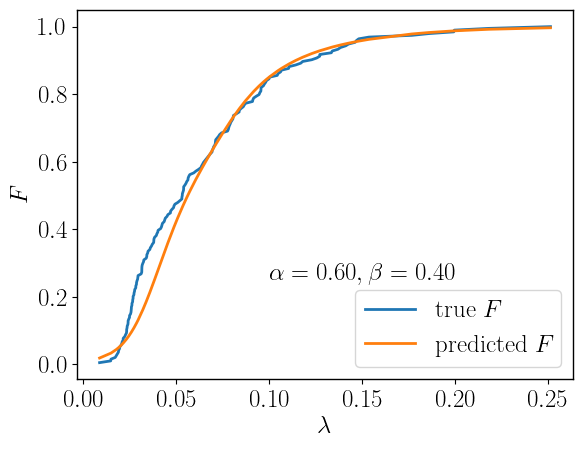

In [229]:
ALPHA=0.6
BETA=0.4
eval_df_single_point, eval_array_single_point = generate_eval_data(alpha=ALPHA,beta=BETA, K=200)
eval_tensor_single_point = torch.Tensor(eval_array_single_point)
CDF_hat = untrained_SIR_model(eval_tensor_single_point).detach().numpy()
lambda_ = eval_df_single_point['li']
true_CDF = eval_df_single_point['true_CDF']

# xmin, xmax = lambda_.min(), lambda_.max()
# ymin, ymax = true_CDF.min(), true_CDF.max()
plt.text(0.1, 0.25, r'$\alpha = %.2f, \beta = %.2f$' % (ALPHA,BETA))
plt.plot(lambda_, true_CDF, label=r'true $F$', linewidth=2)
plt.plot(lambda_, CDF_hat, label = r'predicted $F$',linewidth=2)
plt.ylabel(r'$F$')
plt.xlabel(r'$\lambda$')
plt.legend()
plt.show()

In [272]:
def plot_CDF_agreement(nrows, ncols):
    fig, ax = plt.subplots(nrows,ncols, figsize=(20,20))
    ax = ax.ravel()
    alpha_beta_l = [(alpha, beta) for alpha in np.random.uniform(0,1, nrows) for beta in np.random.uniform(0.2,0.7, ncols)]
    for ind, (alpha, beta) in enumerate(alpha_beta_l):
        eval_df_single_point, eval_array_single_point = generate_eval_data(alpha=alpha,beta=beta, K=300)
        eval_tensor_single_point = torch.Tensor(eval_array_single_point)
        CDF_hat = untrained_SIR_model(eval_tensor_single_point).detach().numpy()
        lambda_ = eval_df_single_point['li']
        true_CDF = eval_df_single_point['true_CDF']

        xmin, xmax = lambda_.min(), lambda_.max()
        ymin, ymax = true_CDF.min(), true_CDF.max()
        xwid = (xmax-xmin)/12
        ywid = (ymax-ymin)/12
        xpos = xmin + 4* xwid
        ypos = ymin + 4* ywid
        ax[ind].text(xpos, ypos, r'$\alpha = %.2f, \beta = %.2f$' % (alpha,beta), fontsize=15)
        ax[ind].plot(lambda_, true_CDF, label=r'true $F$', linewidth=2)
        ax[ind].plot(lambda_, CDF_hat, label = r'predicted $F$',linewidth=2)
        ax[ind].set_ylabel(r'$F$')
        ax[ind].set_xlabel(r'$\lambda$')
        ax[ind].legend()
    plt.tight_layout()
    plt.show()

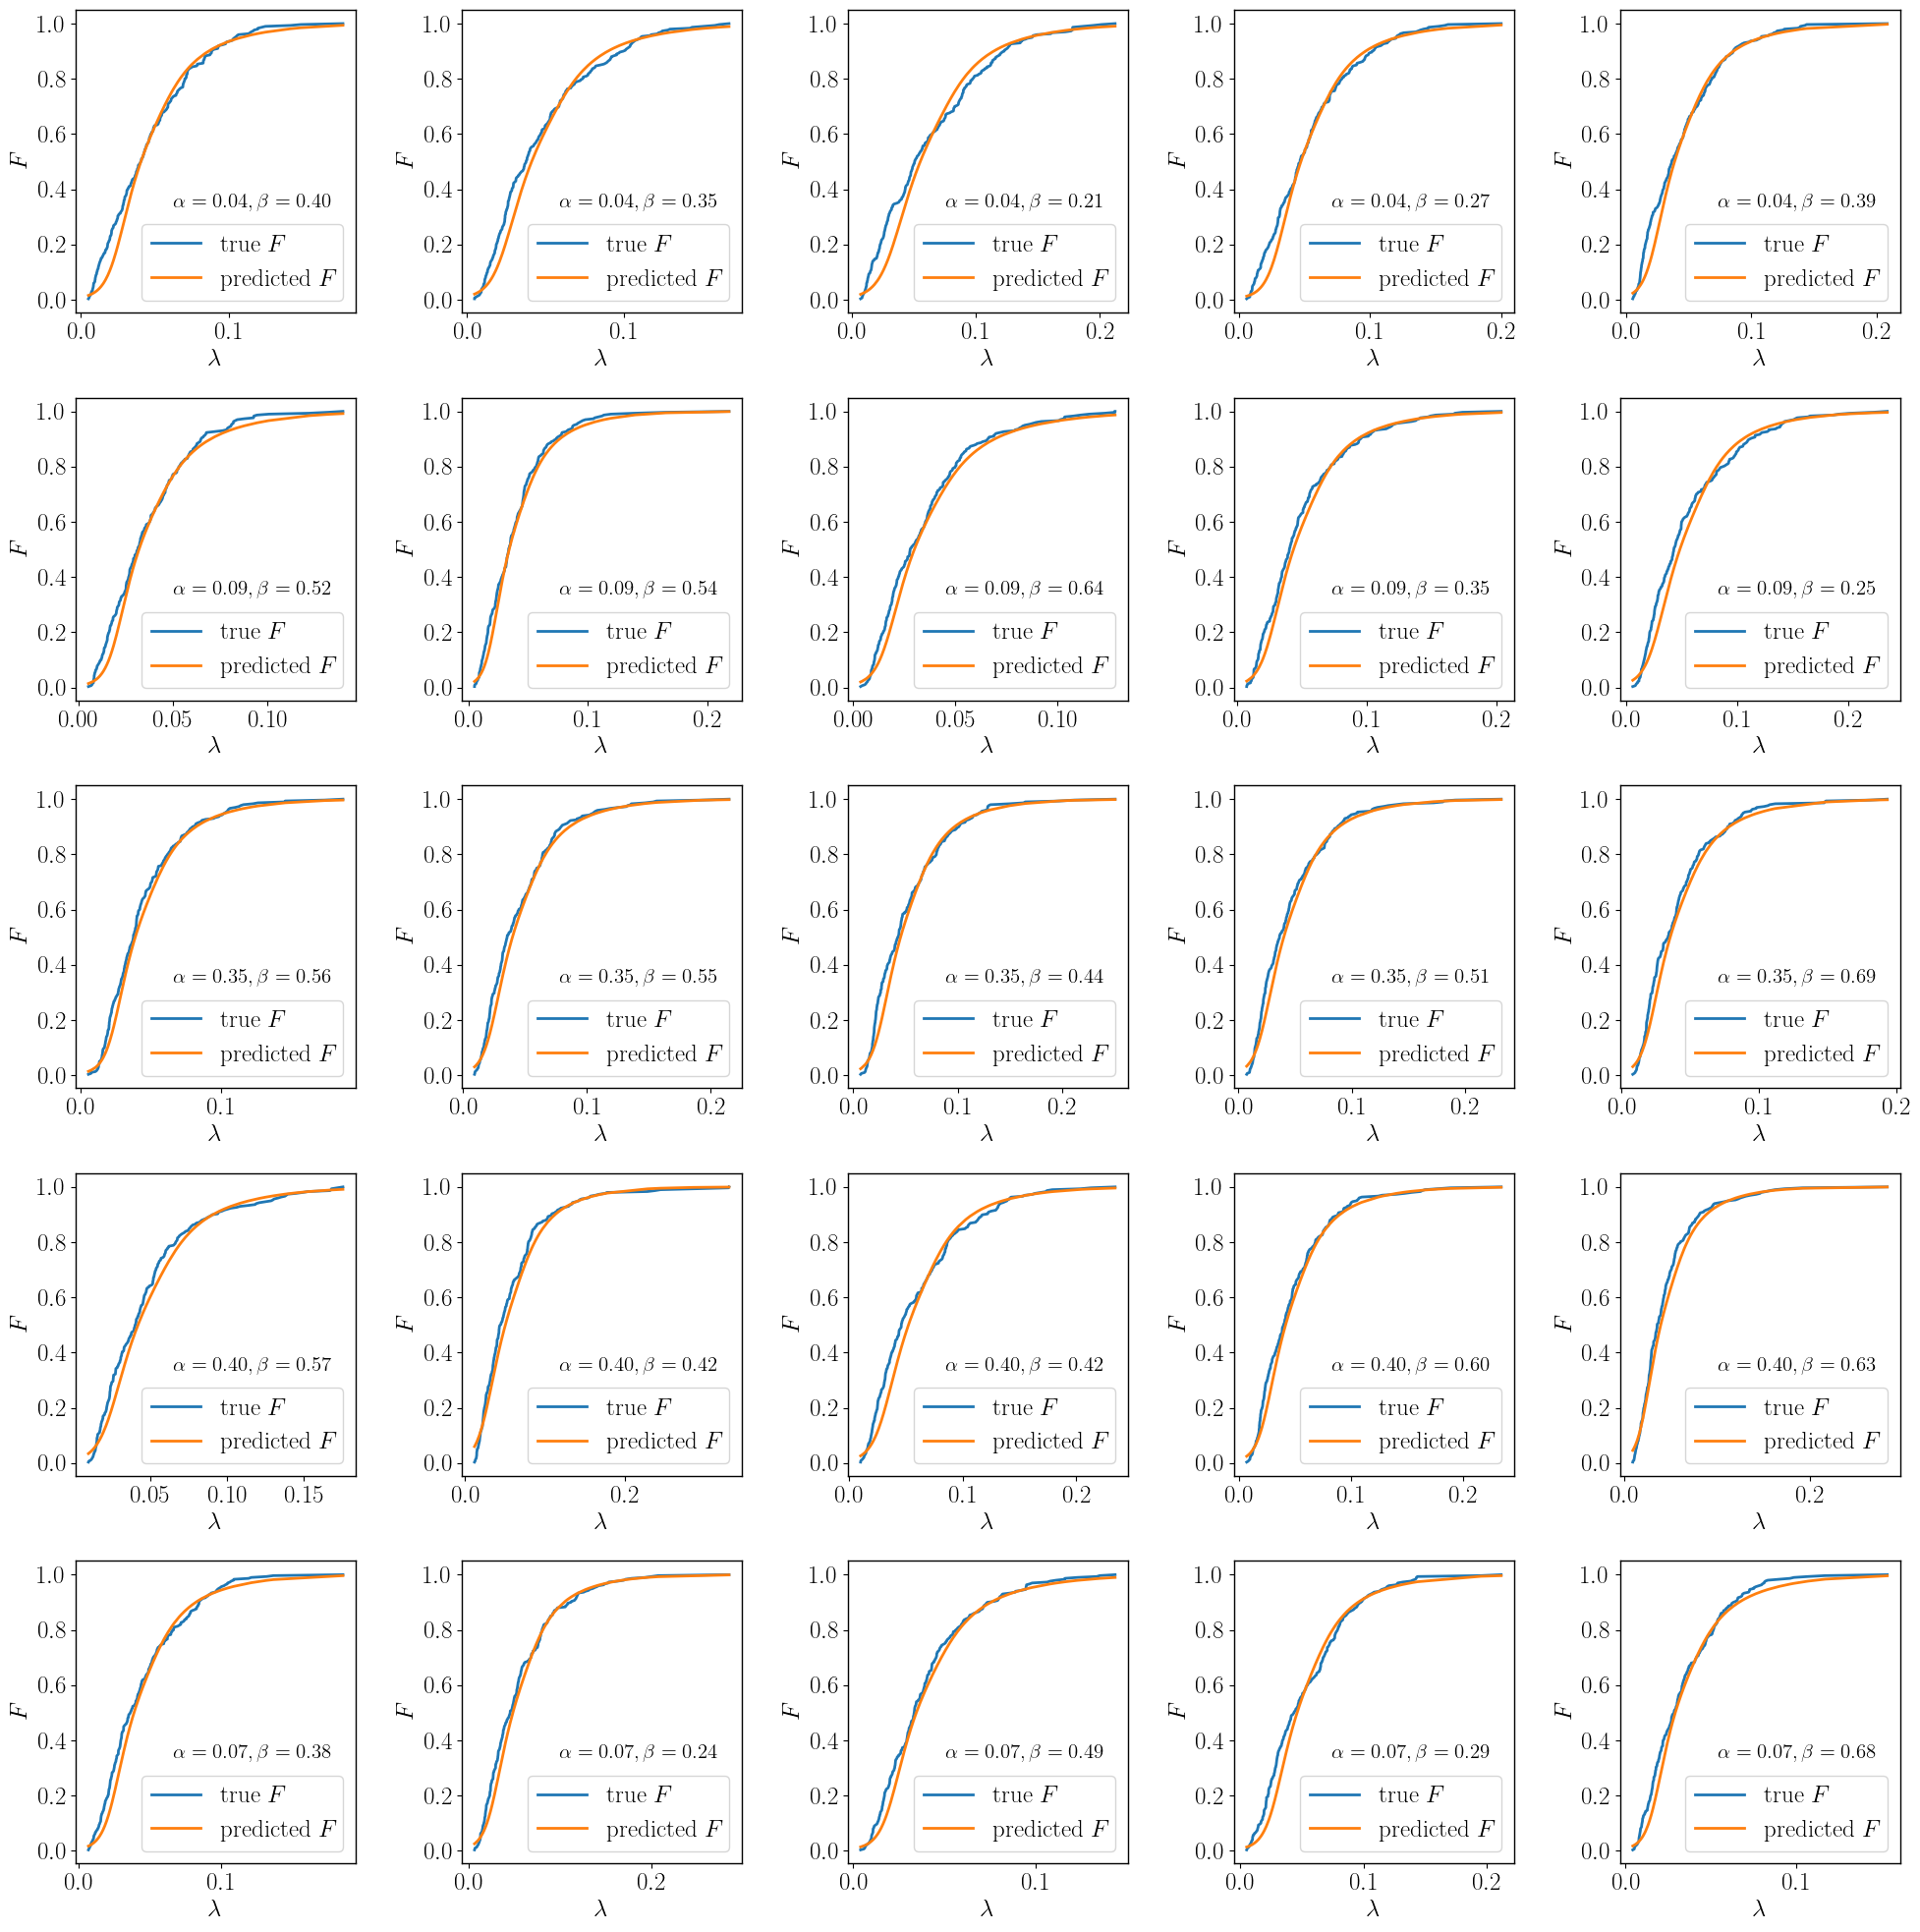

In [273]:
plot_CDF_agreement(nrows=5, ncols=5)